# Phase 6: Proactive Pattern Detection
>_(Part of the Data Science lifecycle for uncovering high-risk clusters & anomalies)_

#### **Objective:**
Use **unsupervised learning** techniques to surface _hidden structure_, such as:
* **Alias clusters** (e.g. same entity across alt names)
* **Outlier behavior** (e.g. odd country associations)
* **Potential identity masking** strategies
#### **Signifance:**
- Extend the model's reach from point-wise prediction to group-wise and behavioral detection - this is what powers **early warning systems** and **entity resolution pipelines** in financial compliance systems.

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

#### **Load & Prepare Features:**

In [77]:
df = pd.read_csv("../data/sanctions_features.csv")
df = df[df["fuzz_ratio_reference"].notna()].copy()

df["is_match"] = ((df["fuzz_ratio"] > 50) & (df["common_token_count"] > 0)).astype(int)

matched_df = df[df["is_match"] == 1].copy()

print(matched_df)

       ent_num            cleaned_name fuzz_ratio_reference  name_length  \
0           36  AEROCARIBBEAN AIRLINES             AIRLINES           22   
5455     10143        BUTEMBO AIRLINES             AIRLINES           16   
5456     10143        BUTEMBO AIRLINES             AIRLINES           16   
16095    13440    SYRIAN ARAB AIRLINES             AIRLINES           20   
16096    13440    SYRIAN ARAB AIRLINES             AIRLINES           20   
16097    13440    SYRIAN ARAB AIRLINES             AIRLINES           20   
16098    13440    SYRIAN ARAB AIRLINES             AIRLINES           20   
19606    17226        CASPIAN AIRLINES             AIRLINES           16   
19607    17226        CASPIAN AIRLINES             AIRLINES           16   
20125    18133       AL NASER AIRLINES             AIRLINES           17   
20199    18133       AL NASER AIRLINES             AIRLINES           17   
20200    18133       AL NASER AIRLINES             AIRLINES           17   
20201    181

#### **Clustering for Alias Networks (DBSCAN):**

Normalize Features

In [78]:
features = ["length_diff", "fuzz_ratio", "common_token_count", "word_count"]
X = StandardScaler().fit_transform(matched_df[features])

Run DBSCAN

In [79]:
db = DBSCAN(eps=0.3, min_samples=3).fit(X)
matched_df["cluster"] = db.labels_

Visualize

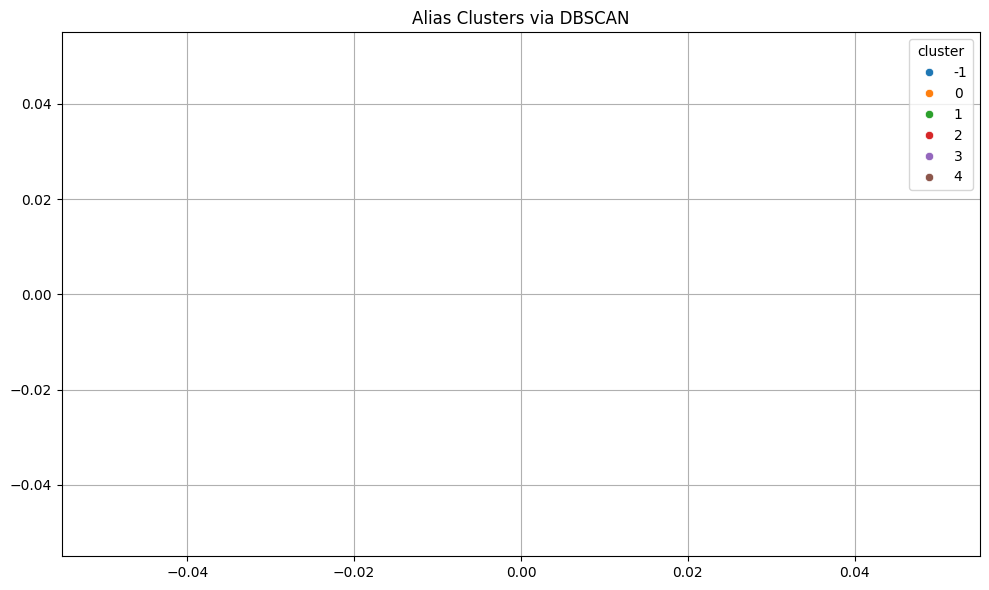

In [80]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], hue=matched_df["cluster"], palette="tab10")
plt.title("Alias Clusters via DBSCAN")
plt.tight_layout()
plt.grid(True)
plt.show()

#### **Outlier Detection (Isolation Forest):**

Train & Predict

In [84]:
anomaly_model = IsolationForest(contamination=0.01, random_state=42)
anomaly_scores = anomaly_model.fit_predict(X)

matched_df["anomaly"] = anomaly_scores
print(matched_df["anomaly"].value_counts())

anomaly
 1    50
-1     1
Name: count, dtype: int64


Export high-risk

In [82]:
anomalies = matched_df[matched_df["anomaly"] == -1]
anomalies[["ent_num", "fuzz_ratio", "length_diff", "common_token_count"]]

print(anomalies)

   ent_num            cleaned_name fuzz_ratio_reference  name_length  \
0       36  AEROCARIBBEAN AIRLINES             AIRLINES           22   

   word_count  has_country_in_name  fuzz_ratio  length_diff  \
0           2                    0       53.33           14   

   common_token_count  is_match  cluster  anomaly  
0                   1         1       -1       -1  


In [ ]:
anomalies.to_csv("../data/high_risk_anomalies.csv", index=False)
matched_df.to_csv("../data/pattern_detection.csv", index=False)
